In [1]:
import sys
sys.path.insert(0, '/workspace/coqui-tts')
import random
import os
import librosa
import numpy as np
import soundfile as sf
from IPython.display import Audio
from tqdm import tqdm
import matplotlib.pyplot as plt
import gruut
from TTS.tts.utils.text import phoneme_to_sequence, _phonemes_to_id, sequence_to_phoneme

## Generate Audios 

In [8]:
prev_name = ' '
prev_start = ' '
prev_end = ' '

for line in tqdm(a):
    
    # Partition File
    split = line.split('|')
    
    # Retrieve Info
    if len(split) == 6:
        file_name = split[0]
        start = int(split[1])
        end = int(split[2])
        text = split[3]
        align = split[4]
        durations = split[5]
    elif len(split) == 4:
        file_name = split[0]
        start = int(split[1])
        end = int(split[2])
        text = split[3]
    else:
        raise NotImplemented
    
    # Check if already in DS
    if ((file_name == prev_name) and (start == prev_start) and (end == prev_end)):
        pass
    else:
        # Load File
        file_raw = 'raw/' + file_name + '.wav'
        x, sr = librosa.load(file_raw)

        # Cut File
        x_start = round(start*sr/1e3)
        x_end = round(end*sr/1e3)
        slic = x[x_start:x_end]

        # Write File
        sf.write('wavs/' + file_name + '__' + str(start) + '.wav', slic, sr)
    
    # Save Current
    prev_name = file_name
    prev_start = start
    prev_end = end
    

100%|████████████████████████████████████████████████████████████████████████████████████████| 108044/108044 [2:26:42<00:00, 12.27it/s]


## Generate Metadata

In [134]:
lines_neb = []
spk = 'NEB'
audios = os.listdir('wavs')
for idx in tqdm(range(len(audios))):
    audio = audios[idx].split('__')
    for line in raw:
        split = line.split('|')
        if ((audio[0] == split[0]) and (audio[1][:-4] == split[1])):
            text = split[3]
            break
    file_path = audios[idx]
    write = file_path + sep + text + sep + spk
    lines_neb.append(write)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 64015/64015 [54:02<00:00, 19.74it/s]


In [177]:
with open('metadata_NEB2' + '.csv', 'w') as f:
    for line in lines:
        line = line.replace('\n','')
        f.write(f"{line}\n")

In [198]:
files_folder = 'wavs/'

## Get Train-Val Split

In [205]:
def blizzard_2023(root_path, meta_file, **kwargs):
    txt_file = os.path.join(root_path, meta_file)
    items = []
    with open(txt_file, "r", encoding="utf-8") as ttf:
        for line in ttf:
            cols = line.split("|")
            wav_file = os.path.join(root_path, "wavs", cols[0])
            text = cols[1]
            spk = cols[2]
            items.append([text, wav_file, spk])
    return items

In [206]:
data = blizzard_2023(os.getcwd(), 'metadata/metadata_neb.csv')

In [291]:
idxs = list(range(len(data)))
random.seed(2)
random.shuffle(idxs)
val_dur = 1*60*60
cur_dur = 0
val_idxs = []
train_idxs = []

for i in idxs:
    x, sr = librosa.load(data[i][1])
    dur = len(x)/sr
    
    if cur_dur < val_dur:
        val_idxs.append(i)
        cur_dur += dur
    else:
        train_idxs.append(i)

In [304]:
train_ds = [metadata[i] for i in train_idxs]
val_ds = [metadata[i] for i in val_idxs]

In [316]:
with open('metadata/metadata_neb_train' + '.csv', 'w') as f:
    for line in train_ds:
        f.write(f"{line}")
        
with open('metadata/metadata_neb_val' + '.csv', 'w') as f:
    for line in val_ds:
        f.write(f"{line}")

## Get Characters

In [ ]:
# get chars again

In [83]:
chars = []
for idx in tqdm(range(len(os.listdir(files_folder)))):
    file_path = os.listdir(files_folder)[idx]
    relative_idx = int(''.join([s for s in file_path if s.isdigit()]))
    chars.extend(list(set(text)))
    chars = list(set(chars))

with open('chars.npy', 'wb') as f:
    np.save(f,chars)
'''
«»{}[]();~¬!?_^-,§|'.":
 \n
abcçdefghijklmnopqrstuvwxyz
âàëéêèîïôûüù
ÊÎÔÂÉÀ
ABCÇDEFGHIJKLMNOPQRSTUVWXYZ
0123456789
'''

100%|████████████████████████████████████████████████████████████████████████████████████████████| 66300/66300 [21:00<00:00, 52.61it/s]


## Phonemes, Spectrograms, Pitch

In [19]:
with open('metadata/metadata_neb_val.csv') as f:
    metadata = f.readlines()

In [24]:
wav_path

'/workspace/coqui-tts/recipes/blizzard_2023/blizzard_2023/wavs/FL_MB_NEB_02_0006__709247.wav'

¬Dès le début, j'ai pensé: il y a du louche!§
idɛ lə deby , ʒe pɑse , il i a dy luʃ !


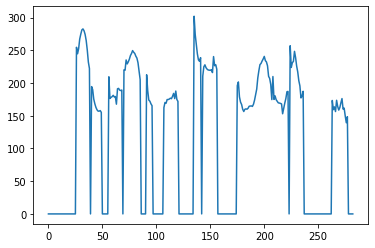

In [32]:
idx = 3
text = metadata[idx].split('|')[1]
phonemes = np.load('/workspace/coqui-tts/experiments/blizzard_2023/phoneme_cache/' + metadata[idx].split('|')[0][:-4] + '_phoneme.npy')
curve = np.load('/workspace/coqui-tts/experiments/blizzard_2023/f0_cache/' + metadata[idx].split('|')[0] + '_pitch.npy')
wav_path = '/workspace/coqui-tts/recipes/blizzard_2023/blizzard_2023/wavs/' + metadata[idx].split('|')[0]
print(text)
print(sequence_to_phoneme(phonemes))
plt.plot(curve)
Audio(librosa.load(wav_path)[0], rate=22050)

In [22]:
phonemizer_args = {
            "remove_stress": True,
            "ipa_minor_breaks": False,  # don't replace commas/semi-colons with IPA |
            "ipa_major_breaks": False,  # don't replace periods with IPA ‖
        }

if True:
            # Use a lexicon/g2p model train on eSpeak IPA instead of gruut IPA.
            # This is intended for backwards compatibility with TTS<=v0.0.13
            # pre-trained models.
            phonemizer_args["model_prefix"] = "espeak"

ph_list = gruut.text_to_phonemes(
    "¬S'il en est ainsi, où diable voulez-vous que je vous prenne, monseigneur?",
    lang='fr',
    return_format="word_phonemes",
    phonemizer_args=phonemizer_args,
)
ph_list

[['(en)', 's', 'i', 'l'],
 ['ɑ̃', 'n'],
 ['ɛ', 't'],
 ['ɛ̃', 's', 'i'],
 [','],
 ['u'],
 ['d', 'j', 'a', 'b', 'l'],
 ['v', 'u', 'l', 'e', 'v', 'u'],
 ['k', 'ə'],
 ['ʒ', 'ə-'],
 ['v', 'u'],
 ['p', 'ʁ', 'ɛ', 'n'],
 [','],
 ['m', 'ɔ̃', 's', 'ɛ', 'ɲ', 'œ', 'ʁ'],
 ['?']]

## Homographs Heterophones

In [305]:
import re
from tqdm import tqdm

In [257]:
with open('hhwords.txt') as f:
    hhwords = f.readlines()

In [258]:
with open('metadata/metadata_neb_train.csv') as f:
    train = f.readlines()

In [276]:
hh_metadata_train = []

for idx in range(len(train)):
    
    line = train[idx]
    text = line.split('|')[1].lower().replace("'", " ").replace("-", " ")
    text = re.sub('[,<>.:;!?«»¬~()§"\[\]]',"", text).split(' ')
    words_in_text = []
    for word in hhwords:
        word = word[:-1].lower()
        
        if word in text:
            words_in_text.append(word)
    
    if words_in_text:
        line = line[:-1] + ('|' + ",".join(words_in_text))
        hh_metadata_train.append(line)

In [277]:
words_occs = []
for idx in range(len(hh_metadata_train)):
    hh_list = hh_metadata_train[idx].split('|')[-1].split(',')
    words_occs.extend(hh_list)

In [278]:
mem = []
for item in words_occs:
    if item not in mem:
        print(str(item) + ' - ' + str(words_occs.count(item)))
        mem.append(item)
    else:
        pass

supporter - 20
est - 4434
plus - 2401
content - 32
tous - 520
but - 47
as - 210
fils - 216
os - 16
sens - 85
hélas - 90
lis - 14
excellent - 28
violent - 15
vis - 39
exprès - 17
parent - 6
notions - 5
bis - 2
convient - 19
cacher - 45
ferment - 10
lut - 26
couvent - 18
actions - 20
portions - 4
reporter - 3
fier - 27
intentions - 3
affluent - 4
évident - 4
affections - 10
négligent - 1
somnolent - 1
sus - 3
résident - 1
urgent - 1


In [346]:
hh_metadata_train

["ES_LMP_NEB_03_0005__615177.wav|,en forçant le maître d'école à supporter ses mauvais traitements sans sourciller.§|NEB|supporter",
 "ES_LMP_NEB_04_0012__1122610.wav|,est ainsi faite qu'un homme simple et naïf,|NEB|est",
 'ES_LMP_NEB_03_0016__454813.wav|,son plus grand plaisir avait été de se charger seule de mon instruction:|NEB|plus',
 "PF_VAMP_NEB_01_0019__33070.wav|.Ajoutons qu'il était bavard, content de lui-même et jaloux de ses chefs.§|NEB|content",
 'PF_VAMP_NEB_01_0015__425656.wav|§Tous les hommes très fins ont un geste particulier,|NEB|tous',
 'PF_VAMP_NEB_01_0018__26236.wav|¬Il faudrait être double, dit-il enfin, et triple et quadruple aussi pour accomplir seulement la moitié de la besogne qui est à ma charge,|NEB|est',
 'JV_TCC_NEB_01_0020__1171501.wav|!Ils allaient éventer leurs voiles, et fuir au plus vite~§|NEB|plus',
 "EC_LFDP_NEB_06_0010__89730.wav|»C'était bien le plus fin voilier qui jamais eût sillonné les mers.§|NEB|plus",
 "JV_TCC_NEB_01_0001__619406.wav|,et qu'i

In [280]:
with open('metadata/metadata_neb_hh_train' + '.csv', 'w') as f:
    for line in hh_metadata_train:
        f.write(f"{line}")

In [138]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [139]:
%%capture
!pip install sentencepiece
!pip install transformers

In [140]:
from transformers import CamembertTokenizer, CamembertForTokenClassification, TokenClassificationPipeline

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [141]:
tokenizer = CamembertTokenizer.from_pretrained('qanastek/pos-french-camembert')

/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [142]:
model = CamembertForTokenClassification.from_pretrained('qanastek/pos-french-camembert')

/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [143]:
pos = TokenClassificationPipeline(model=model, tokenizer=tokenizer)

In [144]:
def make_prediction(sentence):
    labels = [l['entity'] for l in pos(sentence)]
    return list(zip(sentence.split(" "), labels))

In [145]:
text_batch = ["Tu e"]
encoding = tokenizer(text_batch, return_tensors='pt')
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

In [146]:
print(input_ids)

tensor([[  5, 659, 599,   6]])


In [147]:
model(input_ids, attention_mask=attention_mask).logits.shape

torch.Size([1, 4, 65])

In [148]:
pos("Tu as trois")

[{'entity': 'PPER2S',
  'score': 0.7849427,
  'index': 1,
  'word': '▁Tu',
  'start': None,
  'end': None},
 {'entity': 'VERB',
  'score': 0.99949884,
  'index': 2,
  'word': '▁a',
  'start': None,
  'end': None},
 {'entity': 'VERB',
  'score': 0.9997346,
  'index': 3,
  'word': 's',
  'start': None,
  'end': None},
 {'entity': 'CHIF',
  'score': 0.99965334,
  'index': 4,
  'word': '▁trois',
  'start': None,
  'end': None}]

In [149]:
res = make_prediction("Tu as trois as en main.")
res

[('Tu', 'PPER2S'),
 ('as', 'VERB'),
 ('trois', 'VERB'),
 ('as', 'CHIF'),
 ('en', 'NMP'),
 ('main.', 'NMP')]

In [281]:
hh_metadata_train[0].split('|')[1]

",en forçant le maître d'école à supporter ses mauvais traitements sans sourciller.§"

In [318]:
def Convert(tup, di):
    for a, b in tup:
        di.setdefault(a, []).append(b)
    return di

In [319]:
pos_tags = []
for idx in tqdm(range(len(hh_metadata_train))):
    info = hh_metadata_train[idx].split('|')
    text = info[1].lower().replace("'", " ").replace("-", " ")
    text = re.sub('[,<>.:;!?«»¬~()§"\[\]]',"", text)
    hhs = info[-1].split(',')
    dict_tags = {}
    tags = Convert(make_prediction(text), dict_tags)
    
    classes = []
    for word in hhs:
        classes.append(tags[word])
    pos_tags.append(classes)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7971/7971 [1:53:23<00:00,  1.17it/s]


In [343]:
info = hh_metadata_train[24].split('|')
text = info[1].lower().replace("'", " ").replace("-", " ")
text = re.sub('[,<>.:;!?«»¬~()§"\[\]]',"", text)
hhs = info[-1].split(',')
dict_tags = {}
tags = Convert(make_prediction(text), dict_tags)

classes = []
for word in hhs:
    print(word)
    classes.append(tags[word])
classes

est
tous


[['AUX'], ['ADJMP']]

In [344]:
tags

{'eh': ['INTJ'],
 'bien': ['INTJ'],
 'c': ['PDEMMS'],
 'est': ['AUX'],
 'tous': ['ADJMP'],
 'les': ['DET'],
 'jours': ['NMP'],
 'comme': ['PREP'],
 'ça': ['PDEMMS']}

In [345]:
info = hh_metadata_train[24].split('|')
text = info[1].lower().replace("'", " ").replace("-", " ")
text = re.sub('[,<>.:;!?«»¬~()§"\[\]]',"", text)
text

'eh bien c est tous les jours comme ça'

In [326]:
pos_tags

[[['PREP']],
 [['AUX']],
 [['ADV']],
 [['ADJMS']],
 [['ADJMP']],
 [['NFS']],
 [['COCO']],
 [['ADV']],
 [['VERB']],
 [['AUX']],
 [['AUX']],
 [['ADV'], ['DETMS', 'ADJMS']],
 [['ADV']],
 [['AUX']],
 [['AUX']],
 [['VERB']],
 [['ADV']],
 [['PREP']],
 [['AUX']],
 [['ADJMP']],
 [['PROPN']],
 [['AUX'], ['ADV']],
 [['VERB']],
 [['XFAMIL']],
 [['AUX'], ['ADJMP']],
 [['DET']],
 [['PREP']],
 [['VERB']],
 [['AUX']],
 [['VERB']],
 [['VERB']],
 [['AUX']],
 [['ADV'], ['PREP']],
 [['ADV']],
 [['ADV'], ['PINDMP']],
 [['VERB']],
 [['AUX']],
 [['AUX']],
 [['AUX']],
 [['ADV']],
 [['VERB']],
 [['PREP']],
 [['AUX']],
 [['AUX']],
 [['AUX']],
 [['VERB']],
 [['ADV']],
 [['VERB']],
 [['AUX']],
 [['ADV']],
 [['ADV']],
 [['AUX']],
 [['AUX']],
 [['DET']],
 [['AUX']],
 [['NMS']],
 [['VERB']],
 [['VERB']],
 [['AUX']],
 [['AUX']],
 [['ADV']],
 [['PROPN']],
 [['PREP']],
 [['VERB']],
 [['NFS']],
 [['AUX']],
 [['NFS']],
 [['AUX']],
 [['NMS']],
 [['ADV']],
 [['AUX']],
 [['AUX']],
 [['AUX', 'COCO', 'ADV']],
 [['VERB']],
 [

In [322]:
with open('metadata/target' + '.csv', 'w') as f:
    for line in pos_tags:
        f.write(f"{line}\n")